In [1]:
import sys
sys.path.insert(0, '/home/yw440/MXGPY/mxgpy')
sys.path.insert(0, '/home/yw440/MyRGPs/')
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

In [2]:
import scipy.io
from pylab import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
np.random.seed(101)

from mxgpy.rgp.rgp import RGP 
from mxgpy.kernel.rbf import RBF
import mxnet as mx
ctx = mx.gpu()
mx.Context.default_ctx = ctx

 /anaconda/envs/py35/lib/python3.5/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning:OpenSSL.rand is deprecated - you should use os.urandom instead
 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


In [3]:
from mxgpy.util import positive_transform_reverse_numpy
import helper

 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


## RGP - consider joint correlations
- Each joint is dependednt on its parent joint, except for root which doesn't have a parent joint. 
- Each parent joint is treated as a control signal to model the correlation between the joints.
- For root, the control signal is chosen as a constant to represent the walking speed. 


In [5]:
train_motions = ['17', '18', '19', '20']
test_motions = ['21', '22', '07', '08']
subject = '35'
y_bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
             'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
             'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
            'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']
# list of control signal in order
u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
      'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
      'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
      'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

m1 = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=2, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m1['Y'], m1['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m1['Ytest'], m1['lblstest'])


y_train_dict = {'None':None}
y_train_mean_list, y_train_std_list = [],[]
for i, item in enumerate(y_train):
    out, mean, std = helper.normalise_data(item)
    y_train_dict[y_bones[i]] = out
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
       
y_test_dict = {}
y_test_mean_list, y_test_std_list = [], []
for i, item in enumerate(y_test):
    out, mean, std = helper.normalise_data(item)
    y_test_dict[y_bones[i]] = out
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)
    

In [ ]:
## --- Training --- ###
for j, bone in enumerate(y_bones):  
    print(str(j)+'-'+bone)
    y_train = y_train_dict[bone]
    if bone is 'root':
        u_train = [np.ones((np.shape(y_train[0])[0],1)),
                   np.ones((np.shape(y_train[1])[0],1)),
                   np.ones((np.shape(y_train[2])[0],1)),
                   np.ones((np.shape(y_train[3])[0],1))]             
    else:
        u_train = y_train_dict[u_bones[j]] 
        
    YD = np.shape(y_train[0])[1] # dimension of the data, 62 dimension
    UD = np.shape(u_train[0])[1] # dimension of the control signal
     
    ## Initialise model
    win_out = 20 # only consider the feature from previous time step
    win_in = 20
    m_control = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, num_inducing=100,
                    kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], ctx=ctx, dtype=np.float64)
    
    ## Initialize parameters
    m_control.collect_params()['rbf_variance'].set_data(positive_transform_reverse_numpy(np.array([3.]), np.float64))
    m_control.collect_params()['rbf_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*YD+win_in*UD,))*5,np.float64))
    m_control.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.0001]),np.float64))

    ## Train model
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.2)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'null' # fix the noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.1)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'write' # write new noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=1500, step_rate=0.05)

    m_control.save_params('./models/fully_observed/'+str(bone))

0-root
23065484.964762345
17351988.224662095
12879544.16291575
9229588.096214047
6320011.7265757555
4144454.369061683
2648786.0838662563
1701372.2176952725
1133035.7577747912
796058.1134232187
591178.9772921782
460583.3983132437
372401.8509827296
309382.6230678714
262212.9596192672
225674.36759404087
196628.58808501333
173064.85267710686
153631.445319972
137386.8813955173
123652.49912965644
111919.019628118
101792.47874138267
92967.02836399889
85207.04947051505
78330.37374116747
72194.04176244167
66684.83030513691
61714.02998935687
57214.18982823309
53135.79406929192
49442.84798273462
46107.65438368567
43105.71268047629
40411.559688866575
37996.175775154064
35826.60182380819
33868.04887050992
32087.571292747627
30457.452976068536
28956.867139633767
27571.546833492466
26292.066316052485
25111.624140742402
24024.133173725553
23023.098330294135
22101.312714590156
21251.110614530684
20464.893814267158
19735.69431587952
19057.556422593476
18425.611097565845
17835.88516212769
17285.004710559

1940.1050787162387
1936.0083770468561
1931.9328804534875
1927.8782623141665
1923.8441933371728
1919.830342092756
1915.8363756443885
1911.8619600249501
1907.9067615383774
1903.9704471446535
1900.0526856468923
1896.1531489166964
1892.2715124328877
1888.4074567960195
1884.5606680643432
1880.7308394926877
1876.9176725395757
1873.1208771232252
1869.3401732372636
1865.575291327737
1861.8259735105232
1858.0919740108138
1854.3730594970107
1850.6690097640685
1846.9796182869509
1843.3046919722158
1839.6440514518195
1835.9975310137802
1832.3649783897981
1828.7462543981342
1825.141232228605
1821.549797455532
1817.9718463870208
1814.4072855965437
1810.8560313176795
1807.3180072325786
1803.7931443070052
1800.28137905056
1796.7826517271087
1793.2969058051563
1789.8240859227394
1786.3641367292657
1782.917001566328
1779.4826210401923
1776.0609325350051
1772.6518684333382
1769.2553559578382
1765.8713161810524
1762.4996640644124
1759.1403081081623
1755.7931500279478
1752.4580858442396
1749.1350061645412


340.21719854921605
339.6686151528002
338.78316573816426
337.57700565643574
336.44795005515886
335.48142901682394
335.2322353806005
336.38245346983894
337.58267728734074
337.23440803587806
335.33002309024323
334.0267569324301
334.114917972616
334.3473732476142
334.26168809620395
334.021588113752
333.89438608304795
332.65668388097595
330.77903333891743
329.98717907814853
329.772048211257
329.5252720230494
329.5845908819422
330.9710183638088
331.71039369094103
330.1246723312992
328.1502941780928
328.03653912920345
328.066595976708
327.32501677487454
326.467474336406
327.31050087606326
328.6480714543579
328.1241402352814
326.3800215091823
325.19842135932015
325.7708931210922
325.01107848753173
323.2582185164556
323.5392679742904
324.55328726317214
325.20860838525175
324.7531815609539
322.04368620675007
320.8589636303368
321.236421989708
322.29506149895286
322.3318160394381
320.90223474147126
320.53654122717876
321.29290573421144
322.0845546251947
321.92153642304254
319.96655866813194
317.3

In [6]:
y_test_list = []
for j, bone in enumerate(y_bones):  
    y_test_list.append(y_test_dict[bone])
    
u_test_list = [5*np.ones((np.shape(y_test[0][0])[0],1)), 5*np.ones((np.shape(y_test[0][1])[0],1)),
               5*np.ones((np.shape(y_test[0][2])[0],1)), 5*np.ones((np.shape(y_test[0][3])[0],1))]
## collect predictions from different dimensions and concatenate into a large matrix
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
        'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
        'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
        'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']
u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
          'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
          'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
          'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

win_out = 20
win_in = 20
control_signal_dict = {}
num_train_seq = np.shape(y_test_list)[1]
y_pds = [[],[],[],[]]
for i, model in enumerate(bones):
    print ("="*10 + model + "="*10)
    if i==0:
        u_test = u_test_list
    else:
        u_test = control_signal_dict[u_bones[i]]
    u_test_list = []
    for seq in range(num_train_seq):
        y_pd_temp = test_run(model, seq, win_out, win_in, y_test_list[i], u_test, path="./models/fully_observed/", MEAN_PRED=True, with_control=True) # output array
        u_test_list.append(y_pd_temp)
        if i==0:
            y_pds[seq] = y_pd_temp
        else:
            y_pds[seq] = np.hstack((y_pds[seq], y_pd_temp))
    control_signal_dict[model] = u_test_list
    #print(control_signal_dict)



==========root==========
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
Observationa dimension: 6
Control signal dimension: 1
==========lfemur==========
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
==========ltibia==========
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
Observationa dimension: 1
Control signal dimension: 3
==========lfoot==========
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
Observationa dimension: 2
Control signal dimension: 1
==========ltoes==========
Obser

In [10]:
print(helper.compute_MSE(y_test_list, y_pds))

[0.357827378935906, 0.35875541501277414, 0.8999223074898407, 0.9054021331723975]


In [7]:
mean_list = helper.reshape(y_test_mean_list)
std_list = helper.reshape(y_test_std_list)

## write motion files
## Recover data from normalised prediction before writing motion files    
pds = [[],[],[],[]]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, mean_list[seq], std_list[seq])
    
for seq, pd in enumerate(pds):
    filename = './predictions/fully_observed/test_seq'+str(seq)
    helper.write_amc(pd, filename)


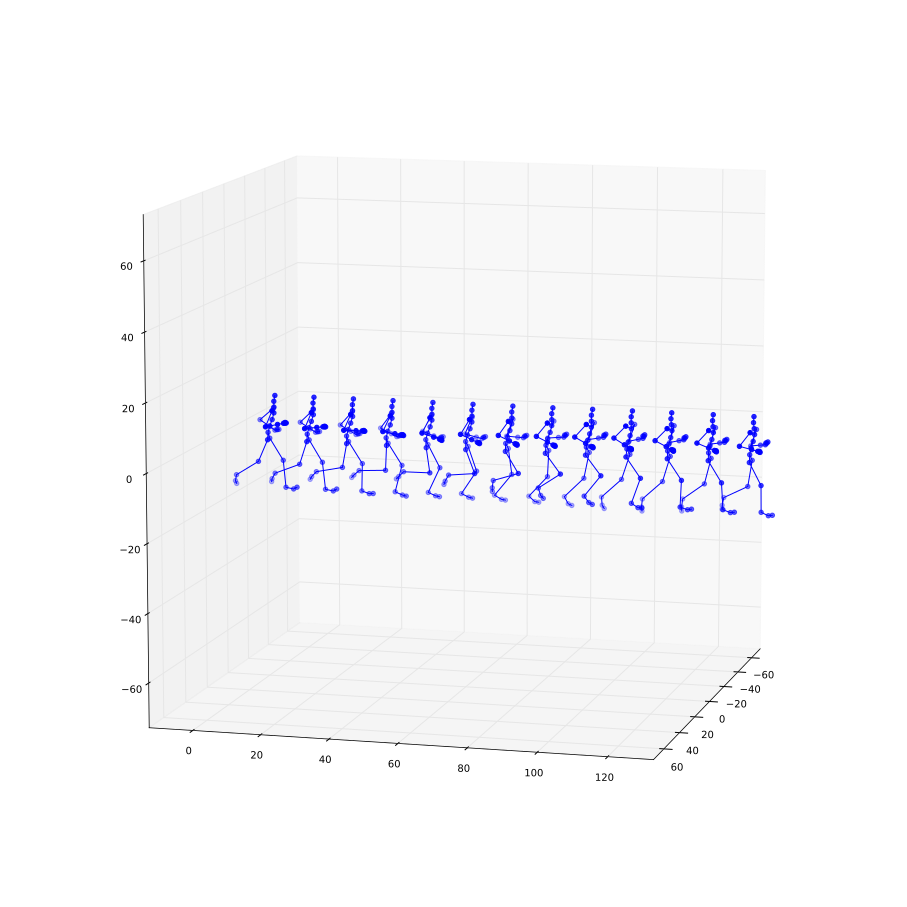

In [9]:
helper.save_trail( (pds[1][:,3:]-mean_list[1][3:])/std_list[1][3:], mean_list[1][3:], std_list[1][3:], m1['skel'], "no_control")

## RGP: consider joint correlations + condition root on delta
- Condition root on its delta values
- condition all other joints on their parents values

In [9]:
train_motions = ['17', '18', '19', '20']
test_motions = ['21', '22', '23', '24']
subject = '35'
y_bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
             'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
             'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
            'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']
# list of control signal in order
u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
      'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
      'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
      'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

m1 = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=2, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m1['Y'], m1['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m1['Ytest'], m1['lblstest'])


y_train_dict = {'None':None}
y_train_mean_list, y_train_std_list = [],[]
for i, item in enumerate(y_train):
    out, mean, std = helper.normalise_data(item)
    y_train_dict[y_bones[i]] = out
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
       
y_test_dict = {}
y_test_mean_list, y_test_std_list = [], []
for i, item in enumerate(y_test):
    out, mean, std = helper.normalise_data(item)
    y_test_dict[y_bones[i]] = out
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)
    

In [5]:
## ----- TRAINING ---- ##
for j, bone in enumerate(y_bones):  
    print(str(j)+'-'+bone)
    
    y_train = y_train_dict[bone]
    if bone is 'root':
        u_train = helper.compute_delta(y_train_dict["root"])
#         for i,item in enumerate(u_train):
#             u_train[i] = item[:,:3]
    else:
        u_train = y_train_dict[u_bones[j]] 
        
    YD = np.shape(y_train[0])[1] # dimension of the data, 62 dimension
    UD = np.shape(u_train[0])[1] # dimension of the control signal

    ## Initialise model
    win_out = 20 # only consider the feature from previous time step
    win_in = 20
    m_control = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, num_inducing=80,
                    kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], ctx=ctx, dtype=np.float64)
    
    ## Initialize parameters
    m_control.collect_params()['rbf_variance'].set_data(positive_transform_reverse_numpy(np.array([3.]), np.float64))
    m_control.collect_params()['rbf_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*YD+win_in*UD,))*5,np.float64))
    m_control.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.0001]),np.float64))

    ## Train model
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.2)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'null' # fix the noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.1)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'write' # write new noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=1500, step_rate=0.06)

    m_control.save_params('./models/delta_control/'+str(bone))
    

0-root


  0%|          | 0/500 [00:00<?, ?it/s]

1-lfemur


  0%|          | 0/500 [00:00<?, ?it/s]

2-ltibia


  0%|          | 0/500 [00:00<?, ?it/s]

3-lfoot


  0%|          | 0/500 [00:00<?, ?it/s]

4-ltoes


  0%|          | 0/500 [00:00<?, ?it/s]

5-rfemur


  0%|          | 0/500 [00:00<?, ?it/s]

6-rtibia


  0%|          | 0/500 [00:00<?, ?it/s]

7-rfoot


  0%|          | 0/500 [00:00<?, ?it/s]

8-rtoes


  0%|          | 0/500 [00:00<?, ?it/s]

9-lowerback


  0%|          | 0/500 [00:00<?, ?it/s]

10-upperback


  0%|          | 0/500 [00:00<?, ?it/s]

11-thorax


  0%|          | 0/500 [00:00<?, ?it/s]

12-lowerneck


  0%|          | 0/500 [00:00<?, ?it/s]

13-upperneck


  0%|          | 0/500 [00:00<?, ?it/s]

14-head


  0%|          | 0/500 [00:00<?, ?it/s]

15-lclavicle


  0%|          | 0/500 [00:00<?, ?it/s]

16-lhumerus


  0%|          | 0/500 [00:00<?, ?it/s]

17-lradius


  0%|          | 0/500 [00:00<?, ?it/s]

18-lwrist


  0%|          | 0/500 [00:00<?, ?it/s]

19-lhand


  0%|          | 0/500 [00:00<?, ?it/s]

20-lfingers


  0%|          | 0/500 [00:00<?, ?it/s]

21-lthumb


  0%|          | 0/500 [00:00<?, ?it/s]

22-rclavicle


  0%|          | 0/500 [00:00<?, ?it/s]

23-rhumerus


  0%|          | 0/500 [00:00<?, ?it/s]

24-rradius


  0%|          | 0/500 [00:00<?, ?it/s]

25-rwrist


  0%|          | 0/500 [00:00<?, ?it/s]

26-rhand


  0%|          | 0/500 [00:00<?, ?it/s]

27-rfingers


  0%|          | 0/500 [00:00<?, ?it/s]

28-rthumb


100%|██████████| 1500/1500 [06:37<00:00,  3.77it/s, loss=333]   


In [4]:
def test_run(model, seq, win_out, win_in, test_data, control_signal, path, MEAN_PRED=True, with_control=True):
    if with_control:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        UD = np.shape(control_signal[0])[-1] ; print('Control signal dimension:', UD)
    
        m = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, 
            num_inducing=80, kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], 
            ctx=ctx, dtype=np.float64)
        #'./models/fully_observed/'
        m.load_params(path+model)
    
        y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:],
                               U=control_signal[seq], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    
    if MEAN_PRED:
        return y_pd_mean
    else:
        return y_pd_mean + y_pd_std*np.random.normal(0,0.5,size=(y_pd_mean.shape[0], y_pd_mean.shape[1]))

In [10]:
## --- Testing --- ##

## collect predictions from different dimensions and concatenate into a large matrix
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
        'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
        'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
        'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']

u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
          'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
          'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
          'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]


y_test_list = []
for j, bone in enumerate(bones):  
    y_test_list.append(y_test_dict[bone])
    
u_test_list = helper.compute_delta(y_test_dict["root"])


win_out = 20
win_in = 20
control_signal_dict = {}
num_train_seq = np.shape(y_test_list)[1]
y_pds = [[],[],[],[]]
for i, model in enumerate(bones):
    print ("="*10 + model + "="*10)
    if i==0:
        u_test = u_test_list
    else:
        u_test = control_signal_dict[u_bones[i]]
    u_test_list = []
    #print(np.shape(u_test[0]))
    #break
    for seq in range(num_train_seq):
        y_pd_temp = test_run(model, seq, win_out, win_in, y_test_list[i], u_test, path='./models/delta_control/', MEAN_PRED=True, with_control=True) # output array
        u_test_list.append(y_pd_temp)
        if i==0:
            y_pds[seq] = y_pd_temp
        else:
            y_pds[seq] = np.hstack((y_pds[seq], y_pd_temp))
    control_signal_dict[model] = u_test_list


==========root==========
Observationa dimension: 6
Control signal dimension: 6
Observationa dimension: 6
Control signal dimension: 6
Observationa dimension: 6
Control signal dimension: 6
Observationa dimension: 6
Control signal dimension: 6
==========lfemur==========
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6
Observationa dimension: 3
Control signal dimension: 6


KeyboardInterrupt: 

In [7]:
mean_list = helper.reshape(y_test_mean_list)
std_list = helper.reshape(y_test_std_list)

## write motion files
## Recover data from normalised prediction before writing motion files    
pds = [[],[],[],[]]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, mean_list[seq], std_list[seq])

    
for seq, pd in enumerate(pds):
    filename = './predictions/delta_control_seq'+str(seq)
    helper.write_amc(pd, filename)


In [12]:
y_pds = np.load("delta_control.npy")

In [13]:
print(helper.compute_MSE(y_test_list, y_pds))

[0.4386423042071387, 0.4810801010921822, 0.353335367602493, 0.388519265865367]


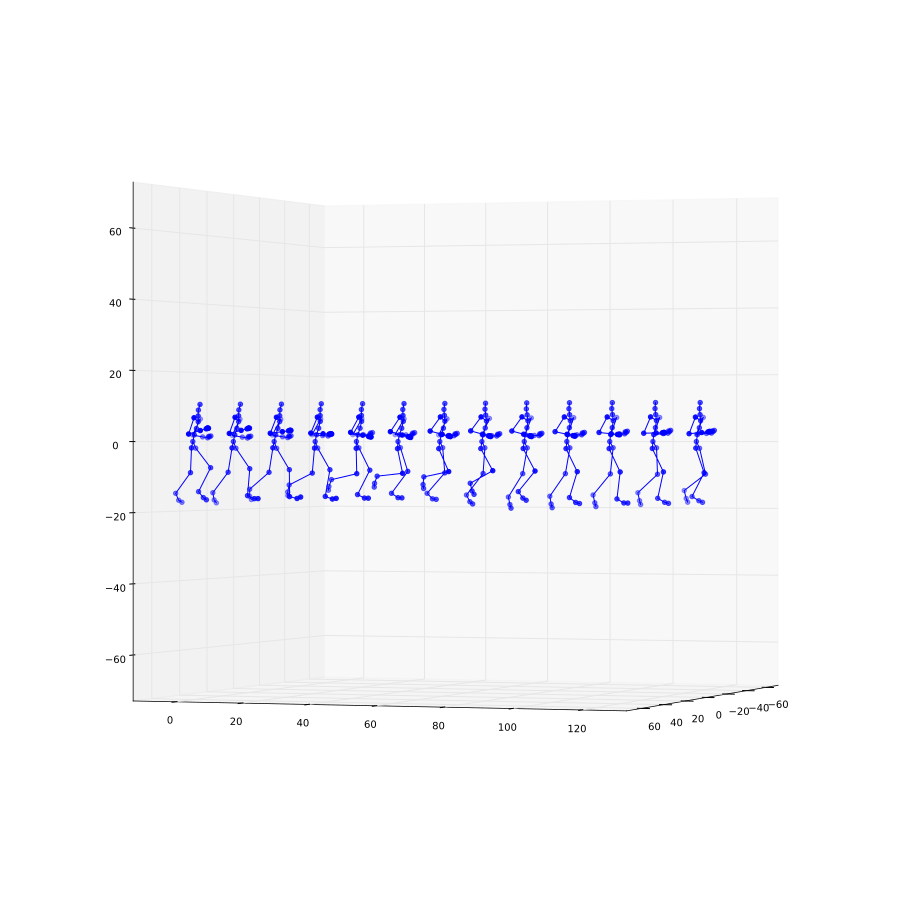

In [8]:
helper.save_trail(y_pds[1][:,3:], mean_list[1][3:], std_list[1][3:], m1['skel'], "delta_control")

# All joints condition on delta

In [10]:
train_motions = ['17', '18', '19', '20']
test_motions = ['21', '22', '23', '24']
subject = '35'
y_bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
             'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
             'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
            'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']
# list of control signal in order
u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
      'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
      'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
      'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

m1 = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=2, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m1['Y'], m1['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m1['Ytest'], m1['lblstest'])


y_train_dict = {'None':None}
y_train_mean_list, y_train_std_list = [],[]
for i, item in enumerate(y_train):
    out, mean, std = helper.normalise_data(item)
    y_train_dict[y_bones[i]] = out
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
       
y_test_dict = {}
y_test_mean_list, y_test_std_list = [], []
for i, item in enumerate(y_test):
    out, mean, std = helper.normalise_data(item)
    y_test_dict[y_bones[i]] = out
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)
    

In [7]:
## ----- TRAINING ---- ##
delta = helper.compute_delta(y_train_dict["root"])
# for i,item in enumerate(delta):
#     delta[i] = item[:,:3]

for j, bone in enumerate(y_bones):  
    print(str(j)+'-'+bone)
    
    y_train = y_train_dict[bone]
    if bone is 'root':
        u_train = delta
    else:
        tmp = y_train_dict[u_bones[j]]
        u_train = [[] for _ in range(np.shape(tmp)[0])]
        for i, item in enumerate(tmp):
            u_train[i] = np.hstack([item, delta[i]])
        
    YD = np.shape(y_train[0])[1] # dimension of the data, 62 dimension
    UD = np.shape(u_train[0])[1] # dimension of the control signal

    ## Initialise model
    win_out = 20 # only consider the feature from previous time step
    win_in = 20
    m_control = RGP(wins=[win_out], with_control=True, X_dims=[YD], U_dim=UD, U_win=win_in, num_inducing=80,
                    kernels=[RBF(win_out*YD+win_in*UD, ARD=True)], ctx=ctx, dtype=np.float64)
    
    ## Initialize parameters
    m_control.collect_params()['rbf_variance'].set_data(positive_transform_reverse_numpy(np.array([3.]), np.float64))
    m_control.collect_params()['rbf_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*YD+win_in*UD,))*5,np.float64))
    m_control.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.0001]),np.float64))

    ## Train model
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.2)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'null' # fix the noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.1)
    m_control.collect_params()['layer_0_noise_var'].grad_req = 'write' # write new noise variance to a single value
    m_control.optimize(Y=y_train, U=u_train, max_iters=1600, step_rate=0.05)

    m_control.save_params('./models/all_control/'+str(bone))
    

  0%|          | 0/500 [00:00<?, ?it/s]

0-root


  0%|          | 0/500 [00:00<?, ?it/s]

1-lfemur


  0%|          | 0/500 [00:00<?, ?it/s]

2-ltibia


  0%|          | 0/500 [00:00<?, ?it/s]

3-lfoot


  0%|          | 0/500 [00:00<?, ?it/s]

4-ltoes


  0%|          | 0/500 [00:00<?, ?it/s]

5-rfemur


  0%|          | 0/500 [00:00<?, ?it/s]

6-rtibia


  0%|          | 0/500 [00:00<?, ?it/s]

7-rfoot


  0%|          | 0/500 [00:00<?, ?it/s]

8-rtoes


  0%|          | 0/500 [00:00<?, ?it/s]

9-lowerback


  0%|          | 0/500 [00:00<?, ?it/s]

10-upperback


  0%|          | 0/500 [00:00<?, ?it/s]

11-thorax


  0%|          | 0/500 [00:00<?, ?it/s]

12-lowerneck


  0%|          | 0/500 [00:00<?, ?it/s]

13-upperneck


  0%|          | 0/500 [00:00<?, ?it/s]

14-head


  0%|          | 0/500 [00:00<?, ?it/s]

15-lclavicle


  0%|          | 0/500 [00:00<?, ?it/s]

16-lhumerus


  0%|          | 0/500 [00:00<?, ?it/s]

17-lradius


  0%|          | 0/500 [00:00<?, ?it/s]

18-lwrist


  0%|          | 0/500 [00:00<?, ?it/s]

19-lhand


  0%|          | 0/500 [00:00<?, ?it/s]

20-lfingers


  0%|          | 0/500 [00:00<?, ?it/s]

21-lthumb


  0%|          | 0/500 [00:00<?, ?it/s]

22-rclavicle


  0%|          | 0/500 [00:00<?, ?it/s]

23-rhumerus


  0%|          | 0/500 [00:00<?, ?it/s]

24-rradius


  0%|          | 0/500 [00:00<?, ?it/s]

25-rwrist


  0%|          | 0/500 [00:00<?, ?it/s]

26-rhand


  0%|          | 0/500 [00:00<?, ?it/s]

27-rfingers


  0%|          | 0/500 [00:00<?, ?it/s]

28-rthumb


100%|██████████| 1600/1600 [05:38<00:00,  4.73it/s, loss=308]   


In [11]:
## --- testing --- ##
y_test_list = []
for j, bone in enumerate(y_bones):  
    y_test_list.append(y_test_dict[bone])
    
delta = helper.compute_delta(y_test_dict["root"])

## collect predictions from different dimensions and concatenate into a large matrix
## This is the correct order
bones = ['root', 'lfemur', 'ltibia', 'lfoot', 'ltoes', 'rfemur', 'rtibia', 'rfoot', 'rtoes', 
        'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck', 'head', 
        'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lfingers', 'lthumb',
        'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb']

u_bones = ['None', 'root', 'lfemur', 'ltibia', 'lfoot', 'root', 'rfemur', 'rtibia', 'rfoot', 
          'root', 'lowerback', 'upperback', 'thorax', 'lowerneck', 'upperneck',
          'thorax', 'lclavicle', 'lhumerus', 'lradius', 'lwrist', 'lhand', 'lwrist',
          'thorax', 'rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rwrist' ]

win_out = 20
win_in = 20
control_signal_dict = {}
num_train_seq = np.shape(y_test_list)[1]
y_pds = [[],[],[],[]]
for i, model in enumerate(bones):
    print ("="*10 + model + "="*10)
    if i==0:
        u_test = delta
    else:
        tmp = control_signal_dict[u_bones[i]]
        u_test = [[] for _ in range(np.shape(tmp)[0])]
        for j, item in enumerate(tmp):
            u_test[j] = np.hstack([item, delta[j]])
        
    u_test_list = []
    #print(np.shape(u_test[0]))
    #print(np.shape(y_test_list[0][0]))
    #break
    for seq in range(num_train_seq):
        y_pd_temp = test_run(model, seq, win_out, win_in, y_test_list[i], u_test, path='./models/all_control/', MEAN_PRED=True, with_control=True) # output array
        u_test_list.append(y_pd_temp)
        if i==0:
            y_pds[seq] = y_pd_temp
        else:
            y_pds[seq] = np.hstack((y_pds[seq], y_pd_temp))
    control_signal_dict[model] = u_test_list


==========root==========
Observationa dimension: 6
Control signal dimension: 6
Observationa dimension: 6
Control signal dimension: 6
Observationa dimension: 6
Control signal dimension: 6
Observationa dimension: 6
Control signal dimension: 6
==========lfemur==========
Observationa dimension: 3
Control signal dimension: 12
Observationa dimension: 3
Control signal dimension: 12
Observationa dimension: 3
Control signal dimension: 12
Observationa dimension: 3
Control signal dimension: 12
==========ltibia==========
Observationa dimension: 1
Control signal dimension: 9
Observationa dimension: 1
Control signal dimension: 9
Observationa dimension: 1
Control signal dimension: 9
Observationa dimension: 1
Control signal dimension: 9
==========lfoot==========
Observationa dimension: 2
Control signal dimension: 7
Observationa dimension: 2
Control signal dimension: 7
Observationa dimension: 2
Control signal dimension: 7
Observationa dimension: 2
Control signal dimension: 7
==========ltoes==========
O

In [12]:
mean_list = helper.reshape(y_test_mean_list)
std_list = helper.reshape(y_test_std_list)

## write motion files
## Recover data from normalised prediction before writing motion files    
pds = [[] for _ in range(np.shape(y_test_mean_list)[-1])]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, mean_list[seq], std_list[seq])
    
for seq, pd in enumerate(pds):
    filename = './predictions/all_control_seq'+str(seq)
    helper.write_amc(pd, filename)


In [14]:
np.save("all_control", y_pds)

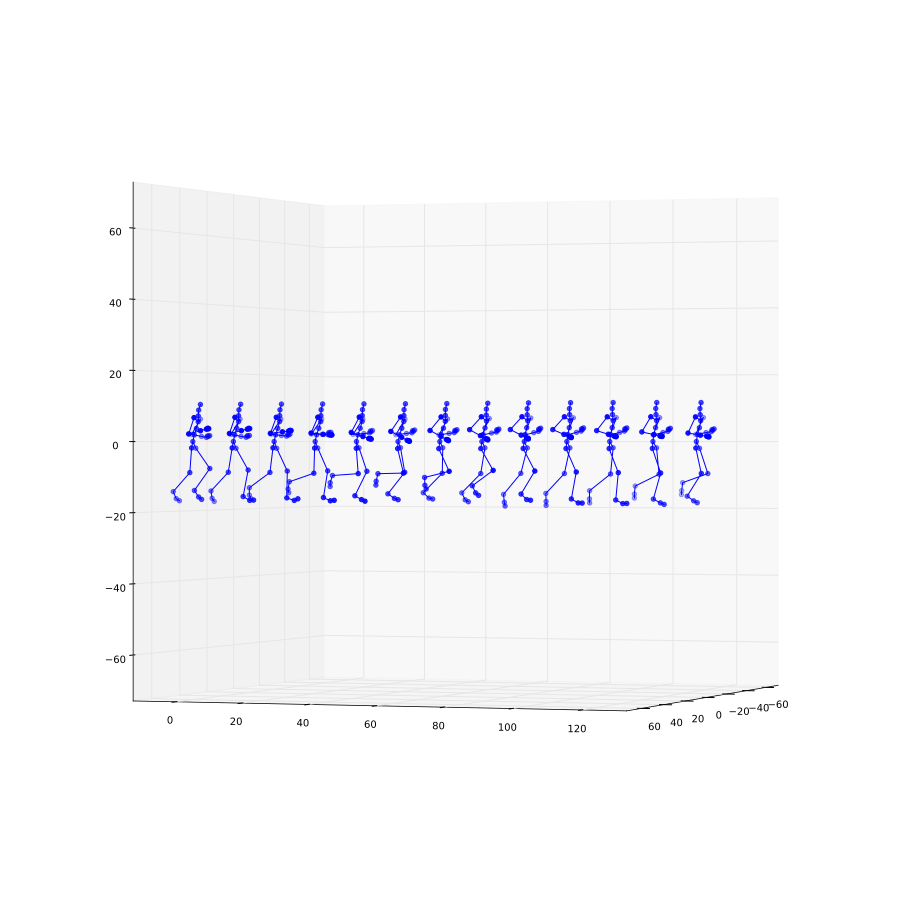

In [13]:
helper.save_trail(y_pds[1][:,3:], mean_list[1][3:], std_list[1][3:], m1['skel'], "all_control")

In [23]:
print(helper.compute_MSE(y_test_list, y_pds))

[0.46628366900704665, 0.5507310096653005, 0.40558530709242796, 0.4312528899220405]
